#Install Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [3]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install --upgrade gensim -qq
    !pip install torchmetrics -qq

    basepath = ('/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7')
    sys.path.append('/content/drive/MyDrive/NLP_UTD/custom-functions')
    
else:
    basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
    sys.path.append('/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions') 

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.5 MB/s eta 0:00:00


In [4]:
from pathlib import Path
base_folder = Path(basepath)
data_folder = base_folder
model_folder = base_folder
embeddings_folder = base_folder
custom_functions = '/content/drive/MyDrive/NLP_UTD/custom-functions'
# sys.path.append(str(custom_functions))
sys.path

['/content',
 '/env/python',
 '/usr/lib/python39.zip',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP_UTD/custom-functions']

In [5]:
# Importing the necessary libraries

from pathlib import Path

from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import custom_preprocessor_mod as cp
from plot_learning_curve import plot_learning_curve as plc

import gensim
from gensim.models import KeyedVectors
import sys
import joblib
from sklearn.model_selection import train_test_split
from gensim_vectorizer  import GensimVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import ast
from sklearn.linear_model import LogisticRegression

In [6]:
gensim.__version__

'4.3.1'

#Load dataset

In [7]:
df = joblib.load('/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/df_multilabel_hw_cleaned.joblib')
df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [17]:
#Getting an error saying no disk space, so reduced the dataset size
df_small = df.sample(frac = 0.3, random_state = 42, replace = False)
x_train, x_test, y_train, y_test = train_test_split(df_small['cleaned_text'], df_small['Tag_Number'], test_size = 0.3, random_state = 42)

# Print the shapes of the resulting datasets
print("Train set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)
y_test[0:3]

Train set shape: (9959,) (9959,)
Test set shape: (4269,) (4269,)


37675    [3, 5]
7724     [3, 5]
44432    [3, 5]
Name: Tag_Number, dtype: object

#Classification Pipeline

In [18]:
pretrained_vector_file = str(embeddings_folder / "cbow_model_AJ.bin")
pretrained_vectors = KeyedVectors.load(pretrained_vector_file)

In [19]:
# Create Pipeline
classifier_full = Pipeline(
    [
        ("vectorizer", GensimVectorizer(pretrained_vectors)),
        ("regressor", LogisticRegression(max_iter=100)),
    ]
)


##Hyperparameter tuning

In [21]:
# Param Grid
param_grid_classifier_full = {
    "regressor__C": [10000000],
}

# GridSearch
grid_classifier_full = GridSearchCV(estimator = classifier_full, param_grid = param_grid_classifier_full, cv = 3, return_train_score=True, n_jobs=-1,scoring='f1_weighted')

In [22]:
grid_classifier_full.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        GensimVectorizer(pretrained_vectors=<gensim.models.keyedvectors.KeyedVectors object at 0x7faf1a001580>)),
                                       ('regressor', LogisticRegression())]),
             n_jobs=-1, param_grid={'regressor__C': [10000000]},
             return_train_score=True, scoring='f1_weighted')

In [23]:
# Let's check the best_parameters from GridSearchCv for our model
print(grid_classifier_full.best_params_)

{'regressor__C': 10000000}


In [25]:
# !rm -r /tmp/

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

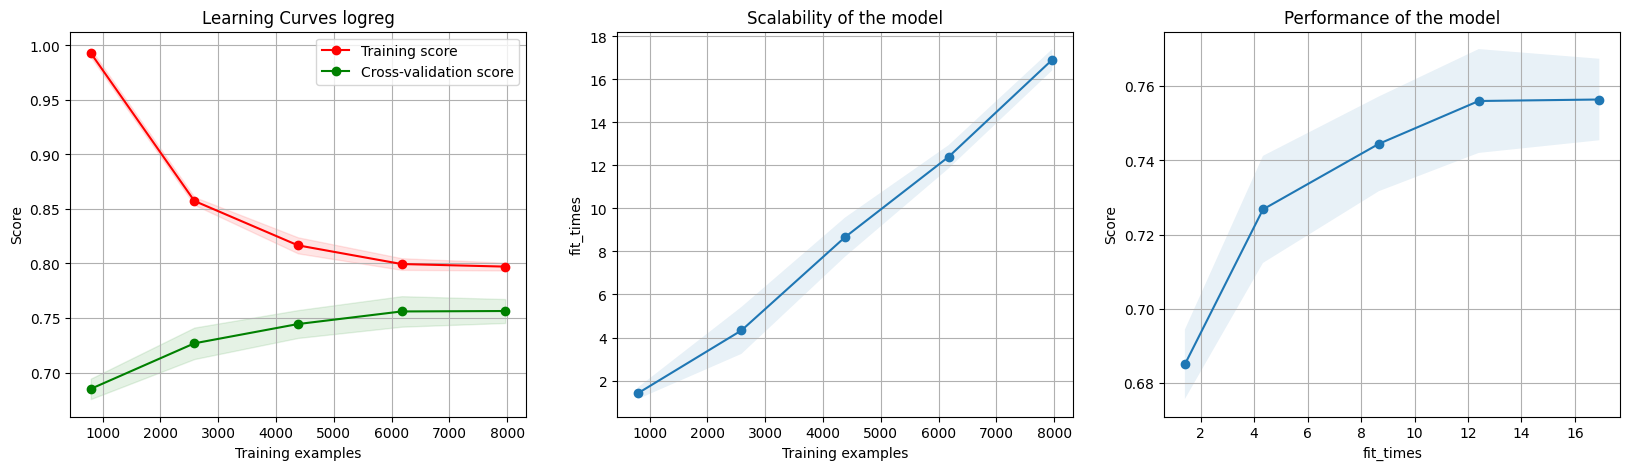

In [27]:
plc(
    grid_classifier_full.best_estimator_,
    "Learning Curves logreg",
    x_train,
    y_train,
    n_jobs=1,
)

In [28]:
# let's check the train scores
print(grid_classifier_full.score(x_train, y_train))

# let's check the cross validation score
print(grid_classifier_full.best_score_)

0.7642080848713493
0.724754421499291


In [29]:
# let's check the test scores
print(grid_classifier_full.score(x_test, y_test))

0.7196157874309895


In [30]:
y_test_pred = grid_classifier_full.predict(x_test)
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

   [0, 1, 3]       0.00      0.00      0.00         1
   [0, 1, 4]       0.00      0.00      0.00         0
   [0, 1, 6]       0.00      0.00      0.00         2
   [0, 1, 7]       0.00      0.00      0.00         2
      [0, 1]       0.48      0.63      0.55        19
   [0, 2, 9]       0.00      0.00      0.00         1
      [0, 2]       0.33      0.14      0.20         7
[0, 3, 5, 9]       0.00      0.00      0.00         9
   [0, 3, 5]       0.00      0.00      0.00         5
[0, 3, 9, 5]       0.00      0.00      0.00         1
   [0, 3, 9]       0.26      0.15      0.19        68
      [0, 3]       0.17      0.19      0.18        21
   [0, 4, 9]       0.00      0.00      0.00         2
      [0, 4]       0.00      0.00      0.00         2
   [0, 5, 9]       0.00      0.00      0.00        21
      [0, 5]       0.00      0.00      0.00         8
      [0, 6]       0.73      0.70      0.71   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

In [32]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-latex-base texlive-latex-extra texlive-latex-recommended
  texlive-pictures tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf

In [33]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task2.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task2.ipynb to pdf
[NbConvertApp] Support files will be in JyotsnaNagaprasad_Ambekar_HW7_task2_files/
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW7_task2_files
[NbConvertApp] Writing 84796 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 146894 bytes to /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_7/JyotsnaNagaprasad_Ambekar_HW7_task2.pdf
